In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

from osgeo import gdal
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd
import rasterio
import rioxarray as rxr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
plt.rcParams['font.family'] = 'Arial'
from matplotlib.ticker import MaxNLocator

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

# import shap
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import train_test_split
# import calendar

In [2]:
inpath = 'C:/Users/bn_li/Desktop/manu1/data/'
outpath = 'D:/figs_manu1/'

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
C:\Users\bn_li\AppData\Local\Temp\ipykernel_15564\2989212469.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(6.5, 9.5, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


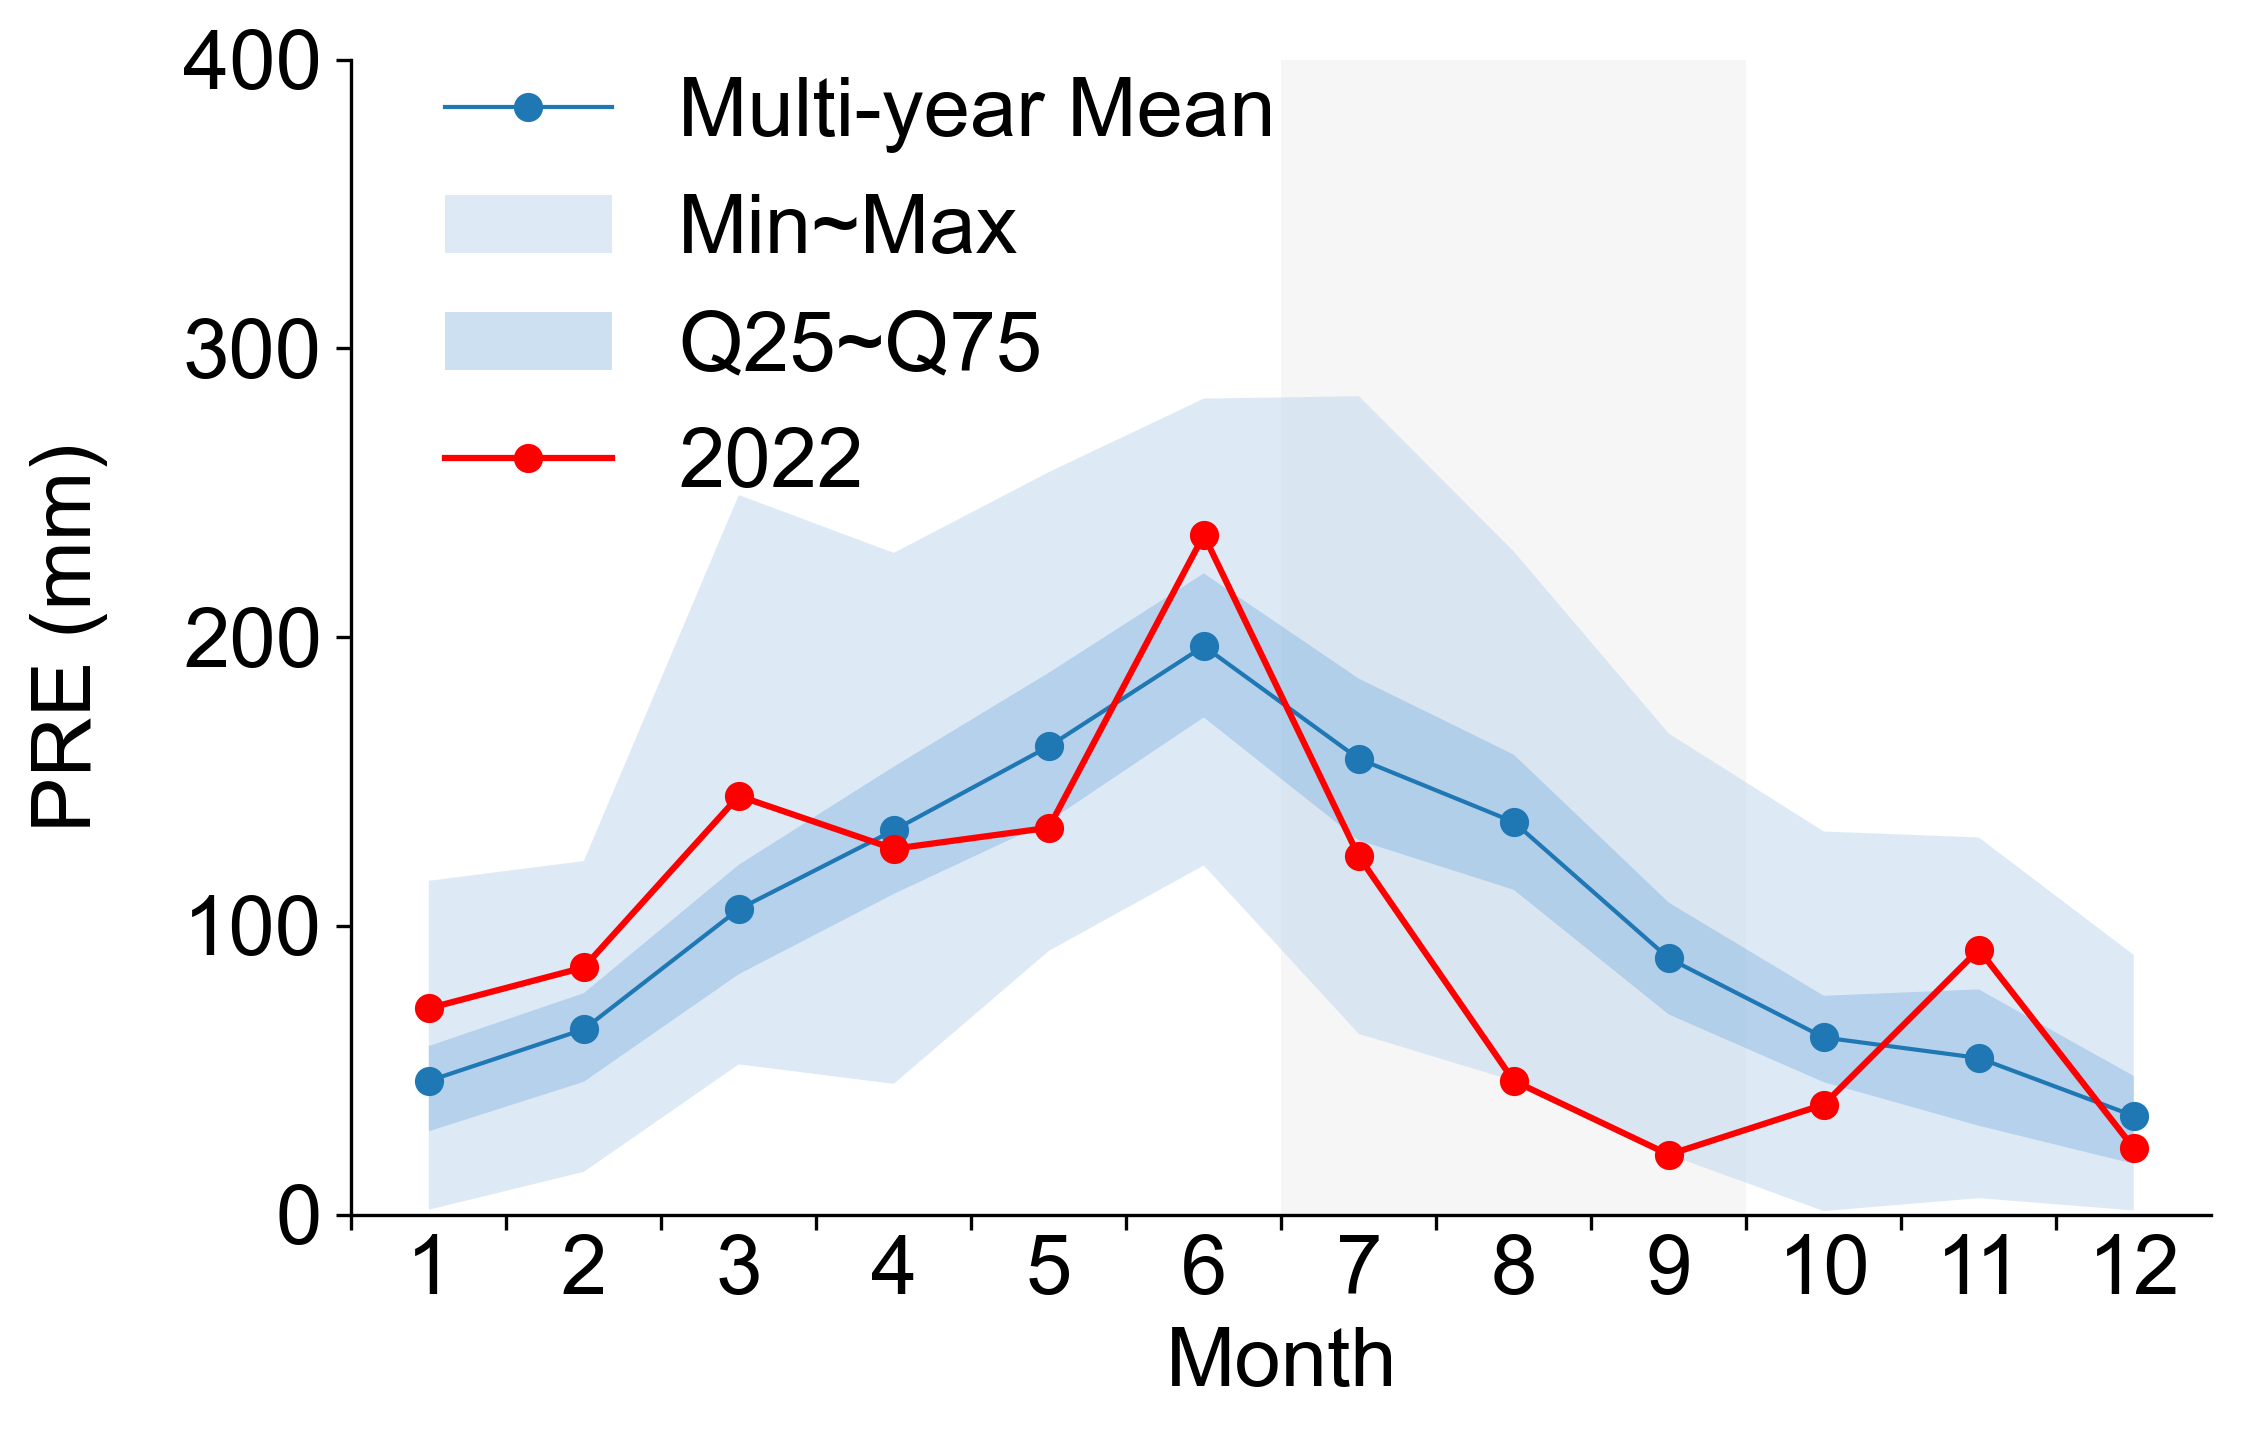

In [3]:
################# 1961-2022 ######################################################
ds = xr.open_dataset(inpath+'shapley/pre_0.05.nc')
ds_m = ds.resample(time='M').sum(skipna=True)
arr = ds_m.mean(dim=['lat','lon'],skipna=True)
df = pd.DataFrame({'time':arr.time.values,'vari':arr['vari'].values})
df.set_index('time',inplace=True)
df_before = df['1961-01-01':'2022-12-31']
df_2022 = df['2022-01-01':'2022-12-31']
Q_list = df_before['vari'].values
Q_before = Q_list.reshape((12, -1), order='F')
Q_list = df_2022['vari'].values
Q_2022 = Q_list.reshape((12, -1), order='F')


fig, ax = plt.subplots(1,1,dpi=300,figsize=(8,5))
dd = np.arange(1,13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvspan(6.5, 9.5, color='lightgray', alpha=0.2, edgecolor='none', linewidth=0)
ax.plot(dd,np.nanmean(Q_before,axis=1),lw=1,ls='-',color='tab:blue', label='Multi-year Mean', marker='o')
ax.fill_between(dd, np.nanmin(Q_before,axis=1),np.nanmax(Q_before,axis=1), color='#BDD7EE',alpha=0.5,label='Min~Max', edgecolor='none')
ax.fill_between(dd, np.nanpercentile(Q_before,q=25,axis=1),np.nanpercentile(Q_before,q=75,axis=1), color='#599AD7',alpha=0.3,label='Q25~Q75', edgecolor='none')
ax.plot(dd, Q_2022,color='r',lw=1.5,label='2022', marker='o')
ax.set_xlim(0.5,12.5)
ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5])
xticklabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
ax.set_xticklabels([])  # Clear the default labels since we will place them manually
new_positions = [1,2,3,4,5,6,7,8,9,10,11,12]
for label, pos in zip(xticklabels, new_positions):
    ax.text(pos, -20, label, ha='center', va='center', fontsize=20) 
ax.set_ylim(0,400)
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel('PRE (mm)',fontsize=20, labelpad=18)
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 1.05), ncol=1, frameon=False, fontsize=20)
ax.set_xlabel('Month', fontsize=20, labelpad=20)

plt.savefig(outpath+'2b.eps', dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
def cal_3month_ano_aver(ds1, mon1, mon2, mon3, start_year, end_year):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').sum(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values
    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(start_year, end_year+1)
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing' or tr=='decreasing':
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                else:
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
    times = pd.date_range(start=f'{start_year}-12-31', end=f'{end_year}-12-31', freq='Y')           
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], times), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

ds = xr.open_dataset('C:/Users/bn_li/Desktop/manu1/data/pre_0.05.nc')
ds_m = ds.resample(time='M').sum(skipna=True)
ds_ano789 = cal_3month_ano_aver(ds_m, 7, 8, 9, 1961, 2022)

ds_ano789.to_netcdf('C:/Users/bn_li/Desktop/manu1/data/pre_0.05_ano.nc')

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\groupby.py:1408: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouper = pd.Grouper(
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\core\concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
C:\Users\bn_li\AppData\Local\Temp\ipykernel_1564\1626878657.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start=f'{start_year}-12

In [3]:
a = xr.open_dataset(inpath+'pre_0.05_ano.nc')
a1 = a['vari'][61,:,:].values
a2 = np.flip(a1, axis=0)
shp_bound = inpath+'shp/basin_lev05.shp'

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


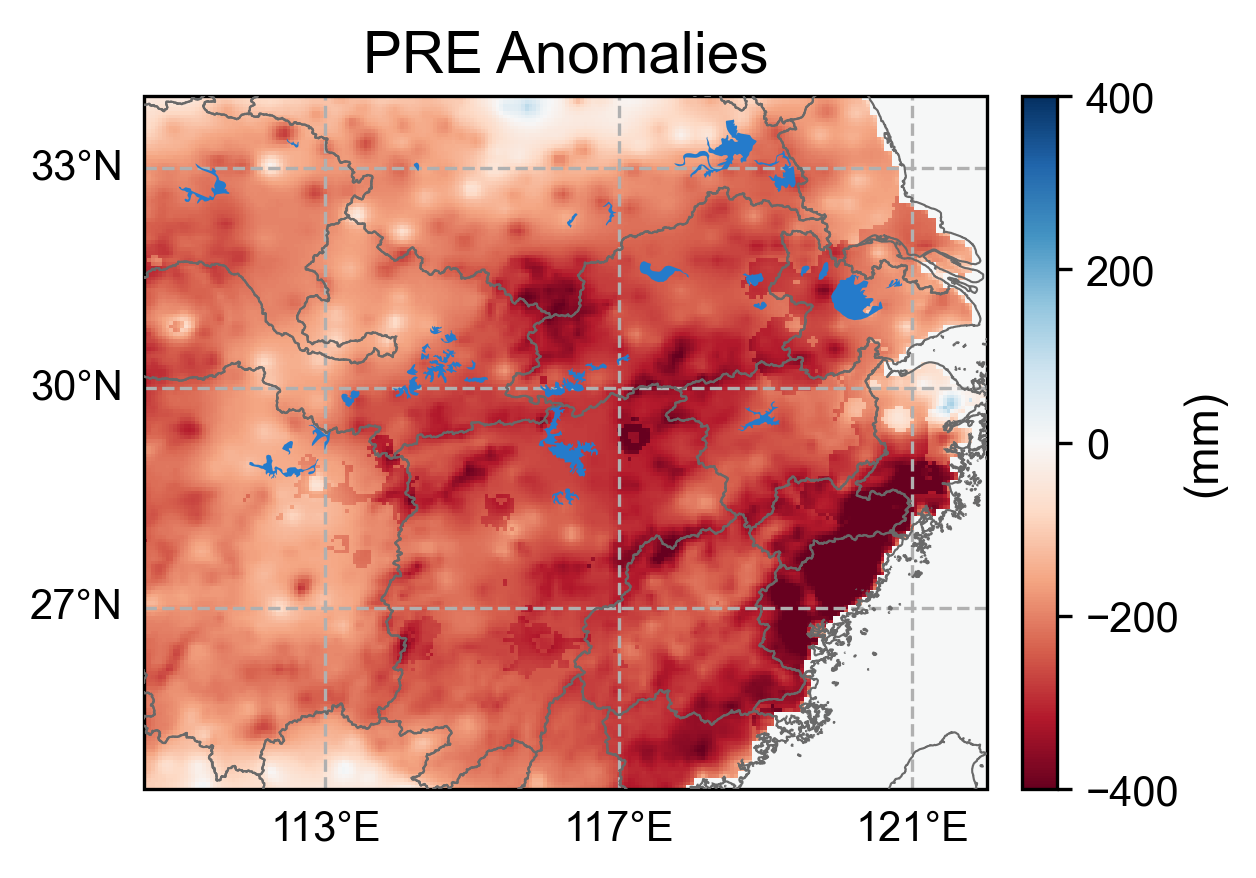

In [4]:
latitude, longitude = a.lat.values, a.lon.values
extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()]
lon_lc = np.linspace(110.5,122,231)
lat_lc = np.linspace(24.5,34,190)

fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
x_ticks = np.arange(109, 124, 4)  # Longitude ticks every 3 degrees
y_ticks = np.arange(24, 34, 3)    # Latitude ticks every 2 degrees

data = a2
title = 'PRE Anomalies'
label = '(mm)'
vmax = 400
vmin = -400
cmap = 'RdBu'


ax.set_extent(extent, crs=ccrs.Geodetic())
pcm = ax.pcolormesh(lon_lc, lat_lc, data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
gridlines = ax.gridlines(draw_labels=True, linestyle='--')
gridlines.xlabels_top = None
gridlines.ylabels_right = None
gridlines.xlocator = mticker.FixedLocator(x_ticks)
gridlines.ylocator = mticker.FixedLocator(y_ticks)
# Read and plot the boundary shapefile
reader_bound = shapereader.Reader(shp_bound)
geometries_bound = list(reader_bound.geometries())
ax.add_geometries(geometries_bound, crs=ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', lw=0.5,zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#257bcb',zorder= 15)
        
ax.set_title(title, fontsize=14)
cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, aspect=20)
ticks = np.linspace(vmin, vmax, 5)
cbar.set_ticks(ticks)
cbar.set_label(label, fontsize=11, labelpad=0.5)

plt.savefig(outpath+'2a.eps', dpi=300, bbox_inches='tight') 
plt.show()

In [5]:
from scipy.stats import gamma
from scipy.special import erfinv

ds = xr.open_dataset(inpath+"shapley/pre_0.05.nc")
precip_daily = ds['vari']

# Resample to monthly
precip_monthly = precip_daily.resample(time='ME').sum(skipna=True)
precip_monthly_rolled = precip_monthly.rolling(time=3, center=False).sum()
precip_np = precip_monthly_rolled.values
time = precip_monthly.time
lat = precip_monthly.lat
lon = precip_monthly.lon

# Prepare empty output
spi = np.full_like(precip_np, np.nan)

for i in range(precip_np.shape[1]):      # lat
    for j in range(precip_np.shape[2]):  # lon
        series = precip_np[:, i, j]

        # Skip if all NaNs
        if np.isnan(series).all():
            continue

        # Remove NaNs and zeros (Gamma cannot handle zeros)
        valid = (~np.isnan(series)) & (series > 0)
        valid_series = series[valid]

        if len(valid_series) < 24:  # minimum length threshold
            continue

        try:
            # Fit Gamma: loc fixed at 0
            alpha, loc, beta = gamma.fit(valid_series, floc=0)

            # Compute CDF
            cdf_vals = gamma.cdf(series[valid], a=alpha, loc=0, scale=beta)

            # Convert CDF to standard normal
            spi_vals = np.full(series.shape, np.nan)
            spi_vals[valid] = np.sqrt(2) * erfinv(2 * cdf_vals - 1)

            spi[:, i, j] = spi_vals

        except Exception as e:
            print(f"Failed at lat={i}, lon={j}: {e}")

valid_time = time[2:]
spi_trimmed = spi[2:, :, :]  # Match the shape

spi_da = xr.DataArray(
    data=spi_trimmed,
    coords={"time": valid_time, "lat": lat, "lon": lon},
    dims=["time", "lat", "lon"],
    name="vari"
)

# Wrap in a Dataset
spi_ds = xr.Dataset({"vari": spi_da})

a1 = spi_ds['vari'].sel(time='2022-07-31').values
a2 = np.flip(a1, axis=0)
b1 = spi_ds['vari'].sel(time='2022-08-31').values
b2 = np.flip(b1, axis=0)
c1 = spi_ds['vari'].sel(time='2022-09-30').values
c2 = np.flip(c1, axis=0)


shp_bound = inpath+'shp/basin_lev05.shp'

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


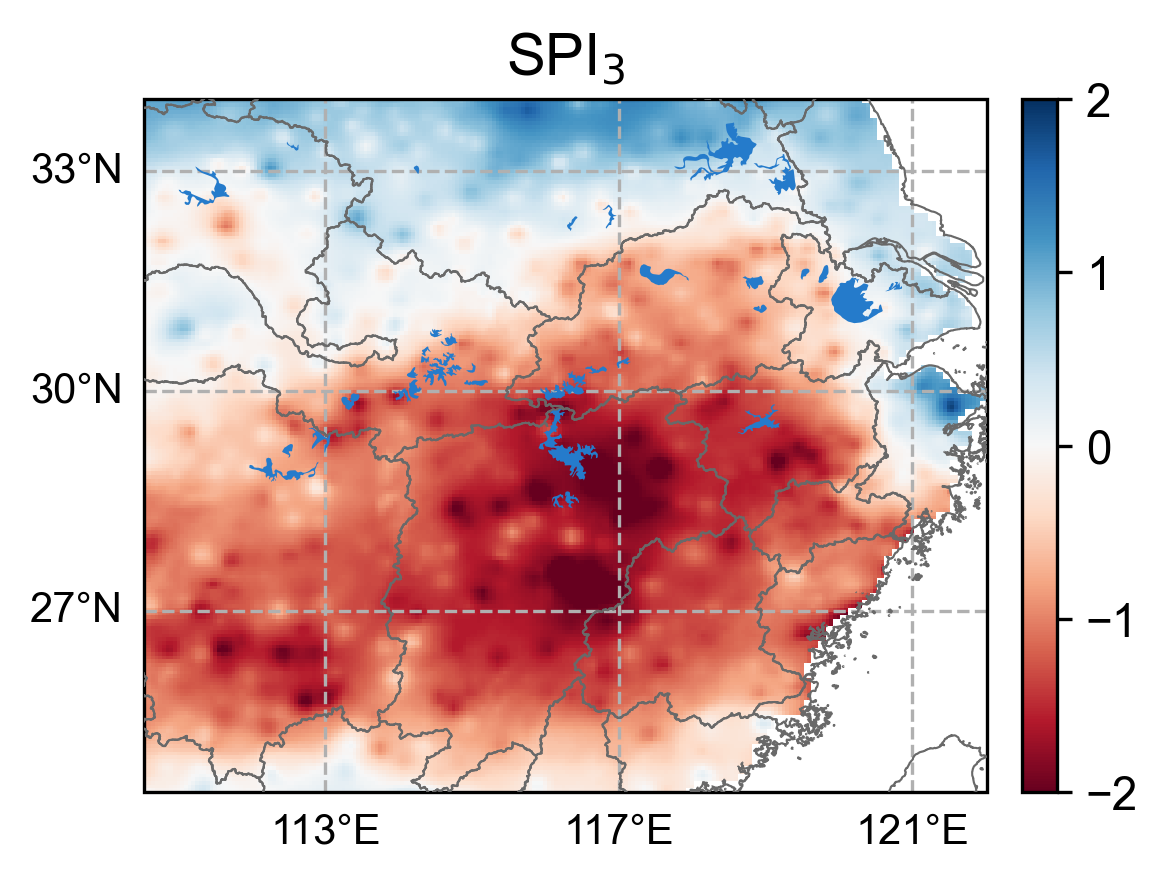

In [6]:
latitude, longitude = spi_ds.lat.values, spi_ds.lon.values
extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()]
lon_lc = np.linspace(110.5,122,231)
lat_lc = np.linspace(24.5,34,190)

fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
x_ticks = np.arange(109, 124, 4)  # Longitude ticks every 3 degrees
y_ticks = np.arange(24, 34, 3)    # Latitude ticks every 2 degrees

data = c2
title = 'SPI$_3$'
label = ''
vmax = 2
vmin = -2
cmap = 'RdBu'


ax.set_extent(extent, crs=ccrs.Geodetic())
pcm = ax.pcolormesh(lon_lc, lat_lc, data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
gridlines = ax.gridlines(draw_labels=True, linestyle='--')
gridlines.xlabels_top = None
gridlines.ylabels_right = None
gridlines.xlocator = mticker.FixedLocator(x_ticks)
gridlines.ylocator = mticker.FixedLocator(y_ticks)
# Read and plot the boundary shapefile
reader_bound = shapereader.Reader(shp_bound)
geometries_bound = list(reader_bound.geometries())
ax.add_geometries(geometries_bound, crs=ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', lw=0.5,zorder=3)
ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#257bcb',zorder= 15)
        
ax.set_title(title, fontsize=14)
cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.03, aspect=20)
ticks = np.linspace(vmin, vmax, 5)
cbar.set_ticks(ticks)
cbar.set_label(label, fontsize=11, labelpad=0.5)
cbar.ax.tick_params(labelsize=11)
plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig(outpath+'2c.eps', dpi=300, bbox_inches='tight') 
plt.show()

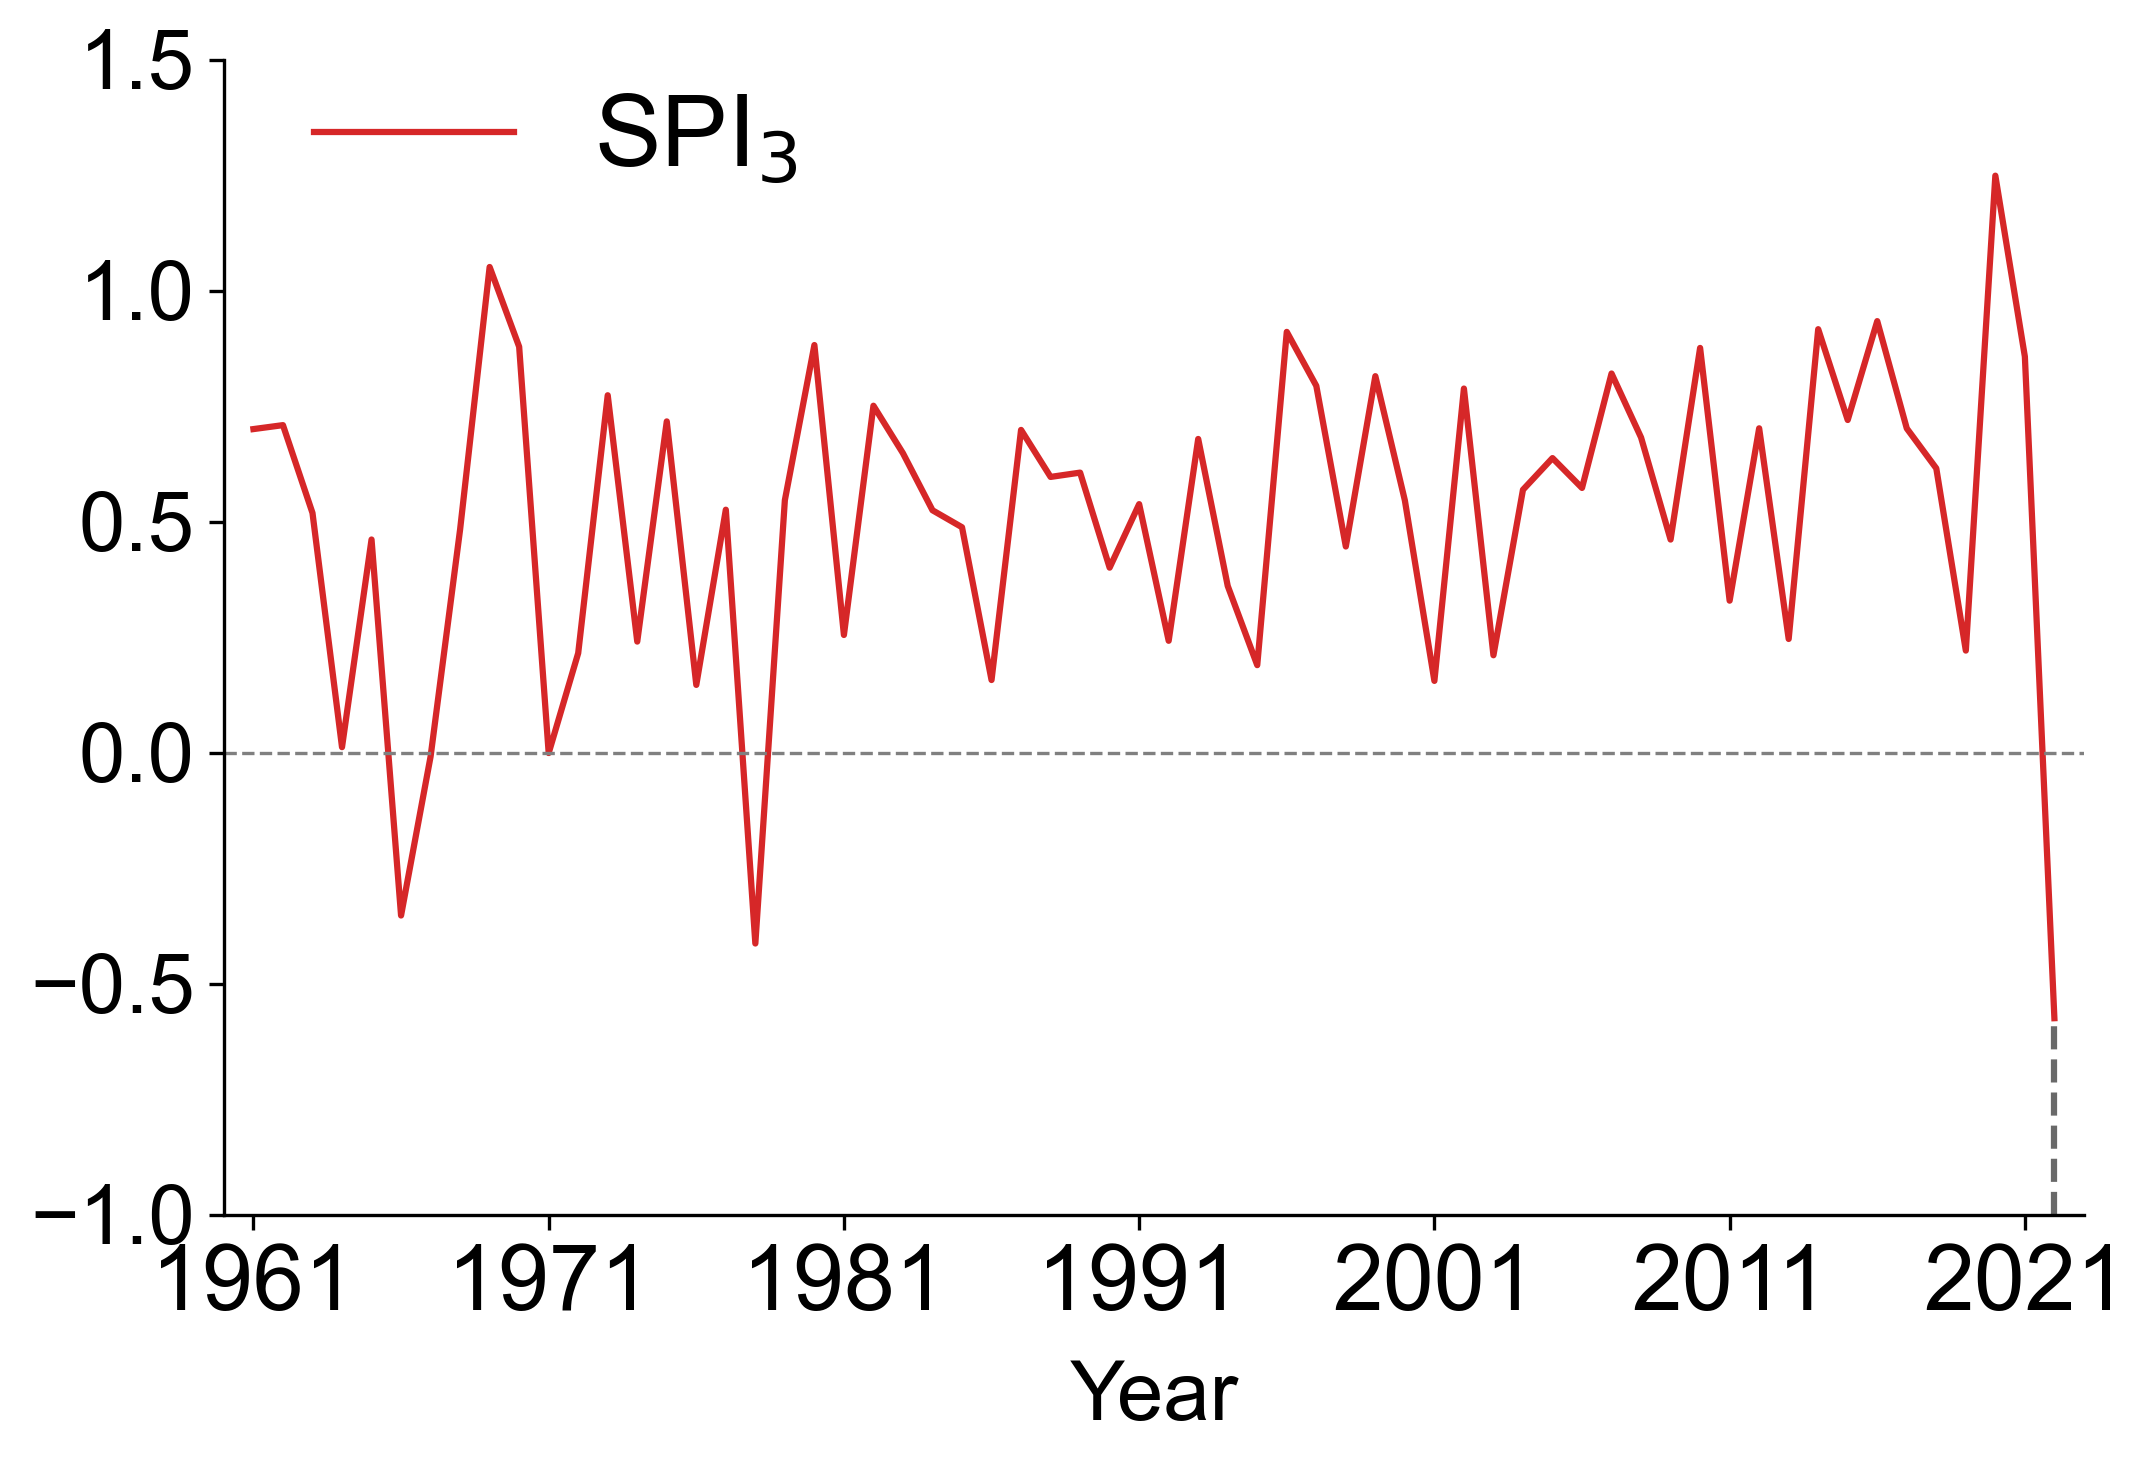

In [47]:
ds_m = spi_ds
arr = ds_m.mean(dim=['lat','lon'],skipna=True)
df = pd.DataFrame({'time':arr.time.values,'vari':arr['vari'].values})
df.set_index('time',inplace=True)


september_30 = df[(df.index.month == 9) & (df.index.day == 30)]
date = np.arange(1961,2023)
v1 = september_30['vari']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(8,5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(date, v1,color='tab:red',lw=1.5, ls='-', label='SPI$_3$')
custom_ticks = np.arange(1961, 2023,10)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels
ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels, fontsize=22)
ax.axhline(y=0, color='gray', linestyle='--',lw=0.8)
ax.set_xlim(date[0]-1, date[-1]+1)
ax.legend(loc='upper left', bbox_to_anchor=(0,1.05), ncol=2, frameon=False, fontsize=24)
ax.set_ylim(-1,1.5)
ax.tick_params(axis='y', labelsize=20)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

ax.set_xlabel('Year', fontsize=20, labelpad=8)

y_value = v1.loc['2022-09-30']
ax.vlines(x=2022, ymin=-1, ymax=y_value, color='dimgray', linestyle='--', lw=1.5)


plt.savefig(outpath+'2d.eps', dpi=1000, bbox_inches='tight') 
plt.show()

In [35]:
c1 = spi_ds['vari'].sel(time='2022-09-30').values
c2 = np.flip(c1, axis=0)

count_below_minus2 = np.sum((c1 <= -1) & ~np.isnan(c1))
total = c1.shape[0]*c1.shape[1]
percent = count_below_minus2/total*100
percent

33.15333789018

In [41]:
spi_mask = spi_ds['vari'].sel(time='2022-09-30').to_dataset()
spi_mask

<xarray.Dataset> Size: 179kB
Dimensions:  (lat: 190, lon: 231)
Coordinates:
    time     datetime64[ns] 8B 2022-09-30
  * lat      (lat) float64 2kB 33.98 33.93 33.88 33.83 ... 24.63 24.58 24.53
  * lon      (lon) float64 2kB 110.5 110.6 110.6 110.7 ... 121.9 122.0 122.0
Data variables:
    vari     (lat, lon) float32 176kB 1.109 1.096 1.086 1.078 ... nan nan nan

In [42]:
spi_mask.to_netcdf(inpath+'spi_mask.nc')